# Generalized workflow for feature extraction

In [1]:
import sys
import os
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('..'))

sys.path.insert(1, module_path + '/src')
import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/models/')
import helper

from sklearn.decomposition import PCA
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.feature_selection import SelectKBest, chi2
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.utils import shuffle

figure_path = module_path + '/figures/'

In [2]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + f'/features/extracted_ts_files/UiT_synthetic_5s_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + f'/features/extracted_ts_files/UiT_synthetic_5s_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + f'/features/extracted_ts_files/UiT_synthetic_5s_VAL.ts')
X_train, y_train = shuffle(X_train, y_train, random_state = 42)


X_train, X_test, X_val = from_nested_to_2d_array(X_train), from_nested_to_2d_array(X_test), from_nested_to_2d_array(X_val)

cols = np.arange(len(X_test.columns))
X_train.columns, X_test.columns, X_val.columns = cols, cols, cols

y_train, y_test, y_val = pd.Series(y_train), pd.Series(y_test), pd.Series(y_val)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train)) 
X_val = pd.DataFrame(scaler.transform(X_val)) 
X_test = pd.DataFrame(scaler.transform(X_test)) 

## Simple classification

In [7]:
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy').fit(X_train, y_train)

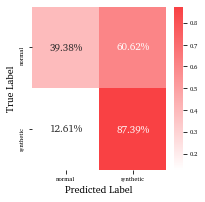

In [18]:
clf = grid.best_estimator_
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test , y_pred, module_path = module_path, class_names = class_names)

f.savefig(figure_path + f'synthetic_compare/synthetic_200Hz_250ms_5s.pdf', bbox_inches='tight')

# CNN

In [3]:
from keras.utils import np_utils
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense


In [57]:
X_train, y_train_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_synthetic_250ms_1000hz_15s_TRAIN.ts')
X_test, y_test_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_synthetic_250ms_1000hz_15s_TEST.ts')
X_val, y_val_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_synthetic_250ms_1000hz_15s_VAL.ts')
X_train, y_train_ = shuffle(X_train, y_train_, random_state = 42)

X_train, X_test, X_val = from_nested_to_2d_array(X_train), from_nested_to_2d_array(X_test), from_nested_to_2d_array(X_val)

cols = np.arange(len(X_test.columns))
X_train.columns, X_test.columns, X_val.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)
X_val, y_val_= shuffle(X_val, y_val_, random_state = 42)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [58]:
le = preprocessing.LabelEncoder()

le.fit(y_train_)
num_classes = len(le.classes_)
y_train = le.transform(y_train_)
y_test = le.transform(y_test_)
y_val = le.transform(y_val_)

y_train = np_utils.to_categorical(y_train, num_classes = num_classes)
y_test = np_utils.to_categorical(y_test, num_classes = num_classes)
y_val = np_utils.to_categorical(y_val, num_classes = num_classes)

In [63]:
batch_size = 100
epochs = 10
input_shape=(X_train.shape[1], 1)


model = Sequential()

model.add(Conv1D(filters=30, kernel_size=20, activation='relu', input_shape=input_shape))
#model.add(BatchNormalization()) 
model.add(MaxPooling1D(pool_size=50))
model.add(Flatten())
model.add(Dense(1500, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy')

In [61]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 74981, 30)         630       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1499, 30)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 44970)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 1500)              67456500  
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 3002      
Total params: 67,460,132
Trainable params: 67,460,132
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit(X_train, y_train, epochs = epochs,
          batch_size = batch_size,
          verbose = 1,
         validation_data = (X_test, y_test))

Epoch 1/10
38/38 [==============================] - 54s 1s/step - loss: 13.1670 - val_loss: 0.7161
Epoch 2/10
38/38 [==============================] - 53s 1s/step - loss: 0.6479 - val_loss: 0.7318
Epoch 3/10
38/38 [==============================] - 53s 1s/step - loss: 0.6162 - val_loss: 0.6969
Epoch 4/10
38/38 [==============================] - 53s 1s/step - loss: 0.5633 - val_loss: 0.6795
Epoch 5/10
38/38 [==============================] - 55s 1s/step - loss: 0.5026 - val_loss: 0.7450
Epoch 6/10
38/38 [==============================] - 55s 1s/step - loss: 0.4621 - val_loss: 0.7158
Epoch 7/10
38/38 [==============================] - 56s 1s/step - loss: 0.4199 - val_loss: 0.7115
Epoch 8/10
38/38 [==============================] - 54s 1s/step - loss: 0.3555 - val_loss: 0.6368
Epoch 9/10
38/38 [==============================] - 54s 1s/step - loss: 0.2803 - val_loss: 0.6585
Epoch 10/10
38/38 [==============================] - 54s 1s/step - loss: 0.2417 - val_loss: 0.5680


In [40]:
y_train_.value_counts()

synthetic    5642
normal       5641
dtype: int64

In [68]:
X_train.shape

(3761, 75000, 1)

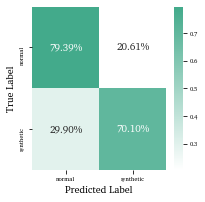

In [66]:
classes = le.classes_

result = model.predict(X_test)
y_pred = np.argmax(result, axis = 1)
y_true = np.argmax(y_test, axis = 1)

f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = classes, color_index = 6)

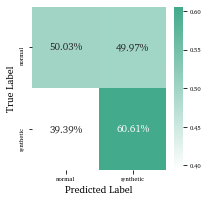

In [55]:
classes = le.classes_

result = model.predict(X_test)
y_pred = np.argmax(result, axis = 1)
y_true = np.argmax(y_test, axis = 1)

f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = classes, color_index = 6)
f.savefig(figure_path + f'synthetic_compare/synthetic_CNN_20ms_400hz_15s.pdf', bbox_inches='tight')